![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src='https://github.com/PracticumAI/practicumai.github.io/blob/main/images/icons/practicumai_beginner.png?raw=true' align='right' width=50>
***

# Hyperparameter Optimization

In this notebook, we will train an image classification model to classify images as bees, wasps, other insects, or other non-insects. The data we will use if from the popular online repository of datasets Kaggle. [Check out the dataset information](https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp). [![Image of bees and wasps from the dataset cover image](images/bees_wasps_dataset-cover.png)]((https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp))

## Getting the data

Even once we have identified the dataset we want to use, getting it can be a challenge. Many AI datasets are large, require authentication even for free datasets, and may require some cleanup before working with them.

You can download the data from Kaggle, but need a free account to do so. Additionally, some additional steps are needed to get the data into a useable format.

Git and GitHub.com are generally not well suited to large files (GitHub limit is generally about 100Mb per file). And if we add all the images individually to the repository, the about 20,000 image files make operations take a long time.

If you are doing this as part of a workshop, we will provide the path to the data. 

We do have the dataset [hosted for download from Dropbox here as a `tar.gz` file](https://www.dropbox.com/s/x70hm8mxqhe7fa6/bee_vs_wasp.tar.gz?dl=0) that you can download and should be ready to use. You can uncomment the lines in the next cell to download and extract the file for use.

### If needed, download the dataset

In [2]:
# This cell is only needed if you need to download the dataset.
# When uncommenting the lines, remove only the "#", leaving the "!"
# Lines in Jupyter that start with a "!" are run as command line commands
#
# Step 1: Download the data
# To download the dataset of bee and wasp images, uncomment the next line.
# !wget https://www.dropbox.com/s/x70hm8mxqhe7fa6/bee_vs_wasp.tar.gz

# Step 2: Uncompress the file. Both steps can be run at once.
# To extract the file that has been downloaded, uncomment the next line
# !tar -xvf bee_vs_wasp.tar.gz

# These two commands should download the file and extract it, producing
# a folder called "bee_vs_wasp" containing four subfolders for each category.

## Import the libraries we will use

In [3]:
import tensorflow as tf   # Import the TensorFlow library, which provides tools for deep learning.
import pandas as pd  # Import the pandas library, used for data manipulation and analysis.

import matplotlib.pyplot as plt  # Import the matplotlib library for plotting and visualization.
# This line allows for the display of plots directly within the Jupyter notebook interface.
%matplotlib inline  
 
# Import Keras libraries
from tensorflow.keras.models import Sequential  # Import the Sequential model: a linear stack of layers from Keras module in TensorFlow.
from tensorflow.keras.layers import Dense  # Import the Dense layer: a fully connected neural network layer from Keras module in TensorFlow.
from tensorflow.keras.layers import Flatten  # Import the Flatten layer: used to convert input data into a 1D array from Keras module in TensorFlow.
from tensorflow.keras.losses import SparseCategoricalCrossentropy  # Import the SparseCategoricalCrossentropy loss function from Keras module in TensorFlow.
from tensorflow.keras import layers 
from tensorflow.keras import losses
from sklearn.metrics import confusion_matrix 
import numpy as np 

## Examine some images

Many of the steps in this notebook have been written as functions. This will make it easier to run these steps repeatedly as you work on optimizing the various hiperparameters.


***********************************************************************
Load data:
  - Loading the dataset from: data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
***********************************************************************
Found 11422 files belonging to 4 classes.
Using 9138 files for training.
Found 11422 files belonging to 4 classes.
Using 2284 files for validation.
['bee', 'other_insect', 'other_noinsect', 'wasp']


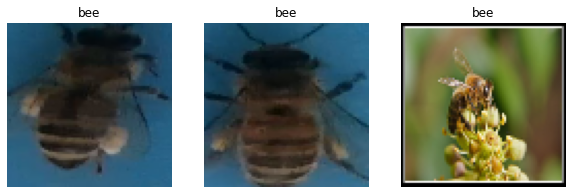

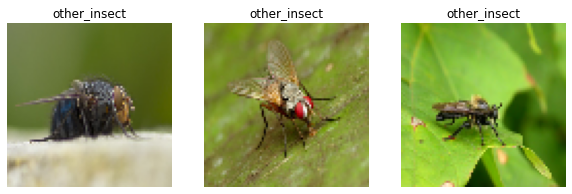

<Figure size 720x720 with 0 Axes>

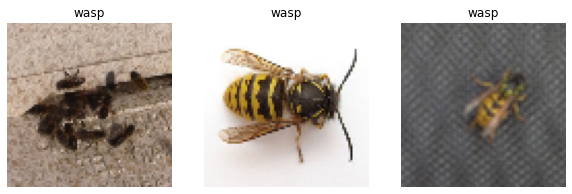

In [6]:
# Be sure to change the path below based on where the data are located.
data_path= "data/bee_vs_wasp"


def load_display_data(path, batch_size=32, shape=(80,80,3), show_pictures=True):
    '''Takes a path, batch size, target shape for images and optionally whether to show sample images.
       Returns training and testing datasets
    '''
    print("***********************************************************************")
    print("Load data:")
    print(f"  - Loading the dataset from: {path}.")
    print(f"  - Using a batch size of: {batch_size}.")
    print(f"  - Resizing input images to: {shape}.")
    print("***********************************************************************")
    # Define the directory path
    directory_path = path
    
    # Define the batch size
    batch_size = batch_size
    
    # Define the image size using the 1st 2 elements of the shape parameter
    # We don't need the number of channels here, just the dimensions to use
    image_size = shape[:2]
    
    # Load the dataset
    X_train = tf.keras.preprocessing.image_dataset_from_directory(
        directory_path,
        batch_size=batch_size,
        image_size=image_size,
        validation_split=0.2,
        subset='training',
        seed=123,
        labels='inferred',
        label_mode='int'
    )
    
    X_test = tf.keras.preprocessing.image_dataset_from_directory(
        directory_path,
        batch_size=batch_size,
        image_size=image_size,
        validation_split=0.2,
        subset='validation',
        seed=123,
        labels='inferred',
        label_mode='int'
    )

    if show_pictures:
        # Get the class names
        class_names = X_train.class_names
        print(class_names)

        # Display up to 3 images from each of the categories
        for i, class_name in enumerate(class_names):
            plt.figure(figsize=(10, 10))
            for images, labels in X_train.take(1):
                images = images.numpy()
                labels = labels.numpy()

                # Filter images of the current class
                class_images = images[labels == i]
                
                # Number of images to show.
                # Limited by number of this class in the batch or specific number
                num_images = min(len(class_images), 3)
                
                for j in range(num_images):
                    ax = plt.subplot(1, num_images, j + 1)
                    plt.imshow(class_images[j].astype("uint8"))
                    plt.title(class_name)
                    plt.axis("off")
            plt.show()
    return X_train, X_test

X_train, X_test = load_display_data(data_path, batch_size=32, shape=(80,80,3), show_pictures=True)


## Make our model

This function created the model we will use.

One hyperparameter to explore is the activation function, which is set when making the model. We start with a ReLU as the default, but you can try others. For simplicity, we will use the same activation function for all but the last layer of the model, but you could potentially change them individually.

The last layer will almost always use a Softmax, which makes all the output values between 0 and 1 and sum to 1--essentially transofrming them into probabilities of the input belongning to each possible class.

In [9]:
def make_model(activation='relu', shape=(80,80,3), num_classes=4):
    '''Sets up a model. 
          Takes in an activation function, shape for the input images, and number of classes.
          Returns the model.'''
    print("***********************************************************************")
    print("Make model:")
    print(f"  - Using the activation function: {activation}.")
    print(f"  - Model will have {num_classes} classes.")
    print("***********************************************************************")
    
    # Define the model
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation=activation, input_shape=shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation=activation),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = make_model()
model.summary()

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                        

## Compile and Train the model

This step compiles the model, getting it ready for training. The main hyperparameters here are the loss function (how we determine how close the predicted output is from the known output values), the optimization function (how we determine what parameters should be updated and how),  the learning rate (how much each parameter should be adjusted), and how many epochs should be run (remember, an epoch is a full pass through all the training data). 

In [15]:

# Define a function that takes an optimizer name as a string
def load_optimizer(optimizer_name):
  # Check if the optimizer name is valid
  if optimizer_name in tf.keras.optimizers.__dict__:
    # Return the corresponding optimizer function
    return tf.keras.optimizers.__dict__[optimizer_name]
  else:
    # Raise an exception if the optimizer name is invalid
    raise ValueError(f"Invalid optimizer name: {optimizer_name}")

def compile_train_model(X_train, X_test, model,
                        loss=SparseCategoricalCrossentropy(from_logits=True),
                        optimizer='Adam', learning_rate=0.0001, epochs=10):
    '''Compiles and trains the model. 
          Takes in an X_train, X_test, model, loss function, optimizer, learning rate,
          and epochs.
          Returns the compiled model and training history.'''
    print("***********************************************************************")
    print("Compile and Train the model:")
    print(f"  - Using the loss funtion: {loss}.")
    print(f"  - Using the optimizer: {optimizer}.")
    print(f"  - Using learning rate of: {learning_rate}.")
    print(f"  - Running for {epochs} epochs.")
    print("***********************************************************************")
    # Compile the model
    
    opt= load_optimizer(optimizer)(learning_rate=learning_rate)
    
    model.compile(optimizer=opt,
                  loss=loss,
                  metrics=['accuracy'])
    # Train the model
    history = model.fit(X_train, epochs=epochs, validation_data=X_test)
    
    return model, history

model, history = compile_train_model(X_train, X_test, model)

***********************************************************************
Compile and Train the model:
  - Using the loss funtion: <keras.losses.SparseCategoricalCrossentropy object at 0x1455d8c7c820>.
  - Using the optimizer: Adam.
  - Using learning rate of: 0.0001.
  - Running for 20 epochs.
***********************************************************************
Epoch 1/20


/apps/tensorflow/2.7.0/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2023-12-10 15:22:21.232753: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-12-10 15:22:22.836850: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


286/286 [==============================] - 7s 14ms/step - loss: 2.8274 - accuracy: 0.5298 - val_loss: 1.3136 - val_accuracy: 0.5950
Epoch 2/20
286/286 [==============================] - 4s 12ms/step - loss: 0.9467 - accuracy: 0.6544 - val_loss: 0.9849 - val_accuracy: 0.6432
Epoch 3/20
286/286 [==============================] - 4s 12ms/step - loss: 0.7224 - accuracy: 0.7240 - val_loss: 0.8793 - val_accuracy: 0.6795
Epoch 4/20
286/286 [==============================] - 4s 12ms/step - loss: 0.5748 - accuracy: 0.7812 - val_loss: 0.8959 - val_accuracy: 0.6799
Epoch 5/20
286/286 [==============================] - 4s 12ms/step - loss: 0.4445 - accuracy: 0.8343 - val_loss: 0.9300 - val_accuracy: 0.7023
Epoch 6/20
286/286 [==============================] - 4s 12ms/step - loss: 0.3513 - accuracy: 0.8765 - val_loss: 0.9051 - val_accuracy: 0.7045
Epoch 7/20
286/286 [==============================] - 4s 12ms/step - loss: 0.2802 - accuracy: 0.9032 - val_loss: 0.9596 - val_accuracy: 0.7045
Epoch 8/20

## Evaluate the model

Now that we have trained our model, let's evaluate how it does.


***********************************************************************
Evaluate the model:
***********************************************************************
72/72 [==============================] - 1s 9ms/step - loss: 1.3916 - accuracy: 0.7277
Test loss: 1.3916059732437134
Test accuracy: 0.7276707291603088


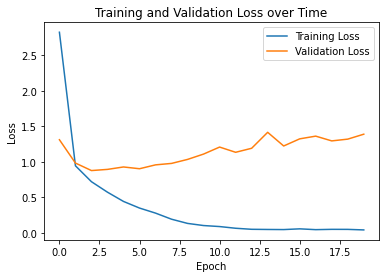

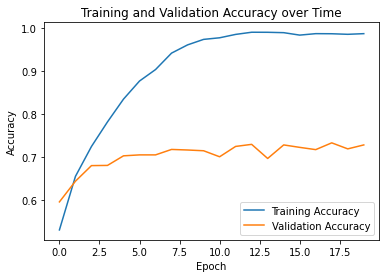

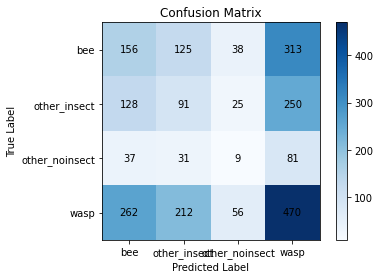

In [16]:
def evaluate_model(X_train, X_test, model, history, num_classes=4):
    '''Evaluates up a model. 
          Takes in an X_train, X_test, model, history, number of classes.'''
    print("***********************************************************************")
    print("Evaluate the model:")
    print("***********************************************************************")
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test)
    print(f'Test loss: {loss}')
    print(f'Test accuracy: {accuracy}')


    # Plot the training and validation loss over time
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot the training and validation accuracy over time
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Get the class names
    class_names = X_test.class_names

    # Make predictions on the test set
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    
    # Get the true labels
    y_true = np.concatenate([y for x, y in X_test], axis=0)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(range(num_classes),class_names)
    plt.yticks(range(num_classes), class_names)
    plt.colorbar()
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.show()

evaluate_model(X_train, X_test, model, history)


## Explore hyperparameters!

OK, we've trained the model once using some decent first guesses. Now we can see if we can do better by exploring some different hyperparameters.

While there are methods to systematically explore different hyperparameters, and to more easily track the results, we will rely on some ad-hoc exploration and keeping everything in the notebook.

The following function pulls all the steps from above into a single function.

In [21]:
def the_whole_shabang(path, batch_size, shape, classes, activation, loss, optimizer, show_pictures=True):
    
    X_train, X_test = load_display_data(data_path, batch_size, shape, show_pictures)
    model = make_model(activation=activation, shape=shape, num_classes=classes)
    model, history = compile_train_model(X_train, X_test, model, loss=loss,
                        optimizer=optimizer, learning_rate=learning_rate, epochs=epochs)
    evaluate_model(X_train, X_test, model, history, classes)

### Copy the next cell and change hyperparameters

You can copy the next cell multiple times and adjust the hyperparameters to compare results.

***********************************************************************
Load data:
  - Loading the dataset from: data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
***********************************************************************
Found 11422 files belonging to 4 classes.
Using 9138 files for training.
Found 11422 files belonging to 4 classes.
Using 2284 files for validation.
['bee', 'other_insect', 'other_noinsect', 'wasp']


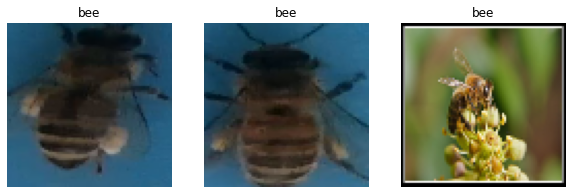

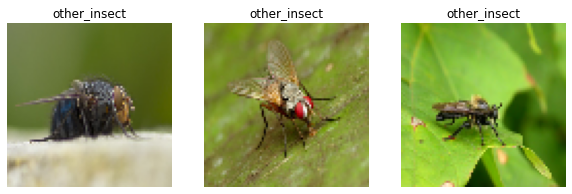

<Figure size 720x720 with 0 Axes>

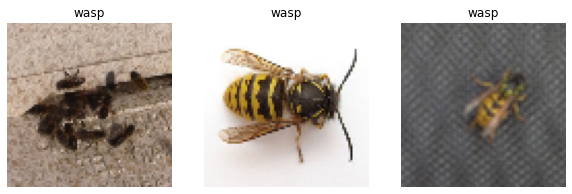

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
***********************************************************************
Compile and Train the model:
  - Using the loss funtion: <keras.losses.SparseCategoricalCrossentropy object at 0x1456c5bb51c0>.
  - Using the optimizer: Adagrad.
  - Using learning rate of: 0.001.
  - Running for 10 epochs.
***********************************************************************
Epoch 1/10


/apps/tensorflow/2.7.0/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


286/286 [==============================] - 4s 13ms/step - loss: 2.8174 - accuracy: 0.5718 - val_loss: 1.0466 - val_accuracy: 0.6252
Epoch 2/10
286/286 [==============================] - 4s 13ms/step - loss: 0.8677 - accuracy: 0.6729 - val_loss: 0.9242 - val_accuracy: 0.6537
Epoch 3/10
286/286 [==============================] - 4s 13ms/step - loss: 0.7524 - accuracy: 0.7088 - val_loss: 0.8538 - val_accuracy: 0.6817
Epoch 4/10
286/286 [==============================] - 4s 12ms/step - loss: 0.6740 - accuracy: 0.7365 - val_loss: 0.8621 - val_accuracy: 0.6804
Epoch 5/10
286/286 [==============================] - 4s 12ms/step - loss: 0.6161 - accuracy: 0.7652 - val_loss: 0.8260 - val_accuracy: 0.6900
Epoch 6/10
286/286 [==============================] - 4s 12ms/step - loss: 0.5671 - accuracy: 0.7875 - val_loss: 1.0158 - val_accuracy: 0.6270
Epoch 7/10
286/286 [==============================] - 4s 12ms/step - loss: 0.5242 - accuracy: 0.8016 - val_loss: 0.8568 - val_accuracy: 0.6773
Epoch 8/10

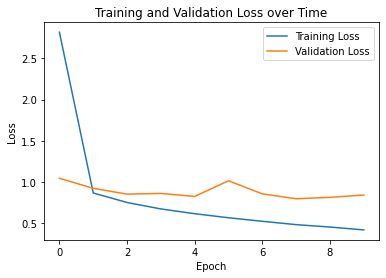

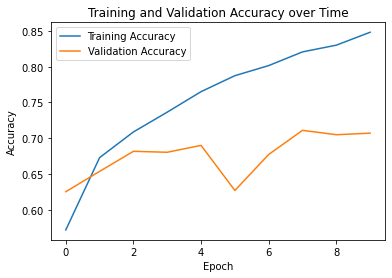

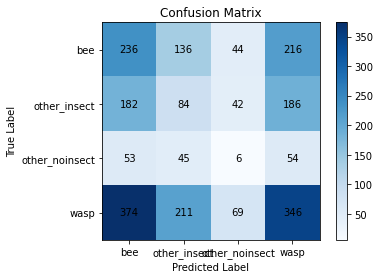

In [23]:
#data_path = 'data/bee_vs_wasp/' # Path to the data.
        # This is defined above, only need to change if you change datasets
    
show_pictures = True # Show sample images from the dataset? Keep on at first, but may become distracting.
                     # Set to False to turn off
# Hyperparameters
shape = (80,80,3)  # Dimensions to use for the images...the raw data are 80x80
                   #  color images, but you could down-sample them
                   #  or convert them to black and white if you wanted
batch_size = 32  # What batch size to use
classes = 4 # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
            # Only change this if you change the dataset
activation='relu' # The activation function is an important hyperparameter
                  # Other activations functions to try: tanh, sigmoid

loss=SparseCategoricalCrossentropy(from_logits=True) # Loss function
        # Other loss functions to try: CatergoricalCrossentropy

optimizer='Adagrad' # Optimizer: others to try: Adam, RMSprop, Adagrad 

learning_rate=0.001 # Try increasing or decreasing the learning rate by an order of magnitude

epochs = 10 # Try running more epochs

# Run everything with these hyperparameters
the_whole_shabang(path, batch_size, shape, classes, activation, loss, optimizer, show_pictures)